/home/nkachappilly/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


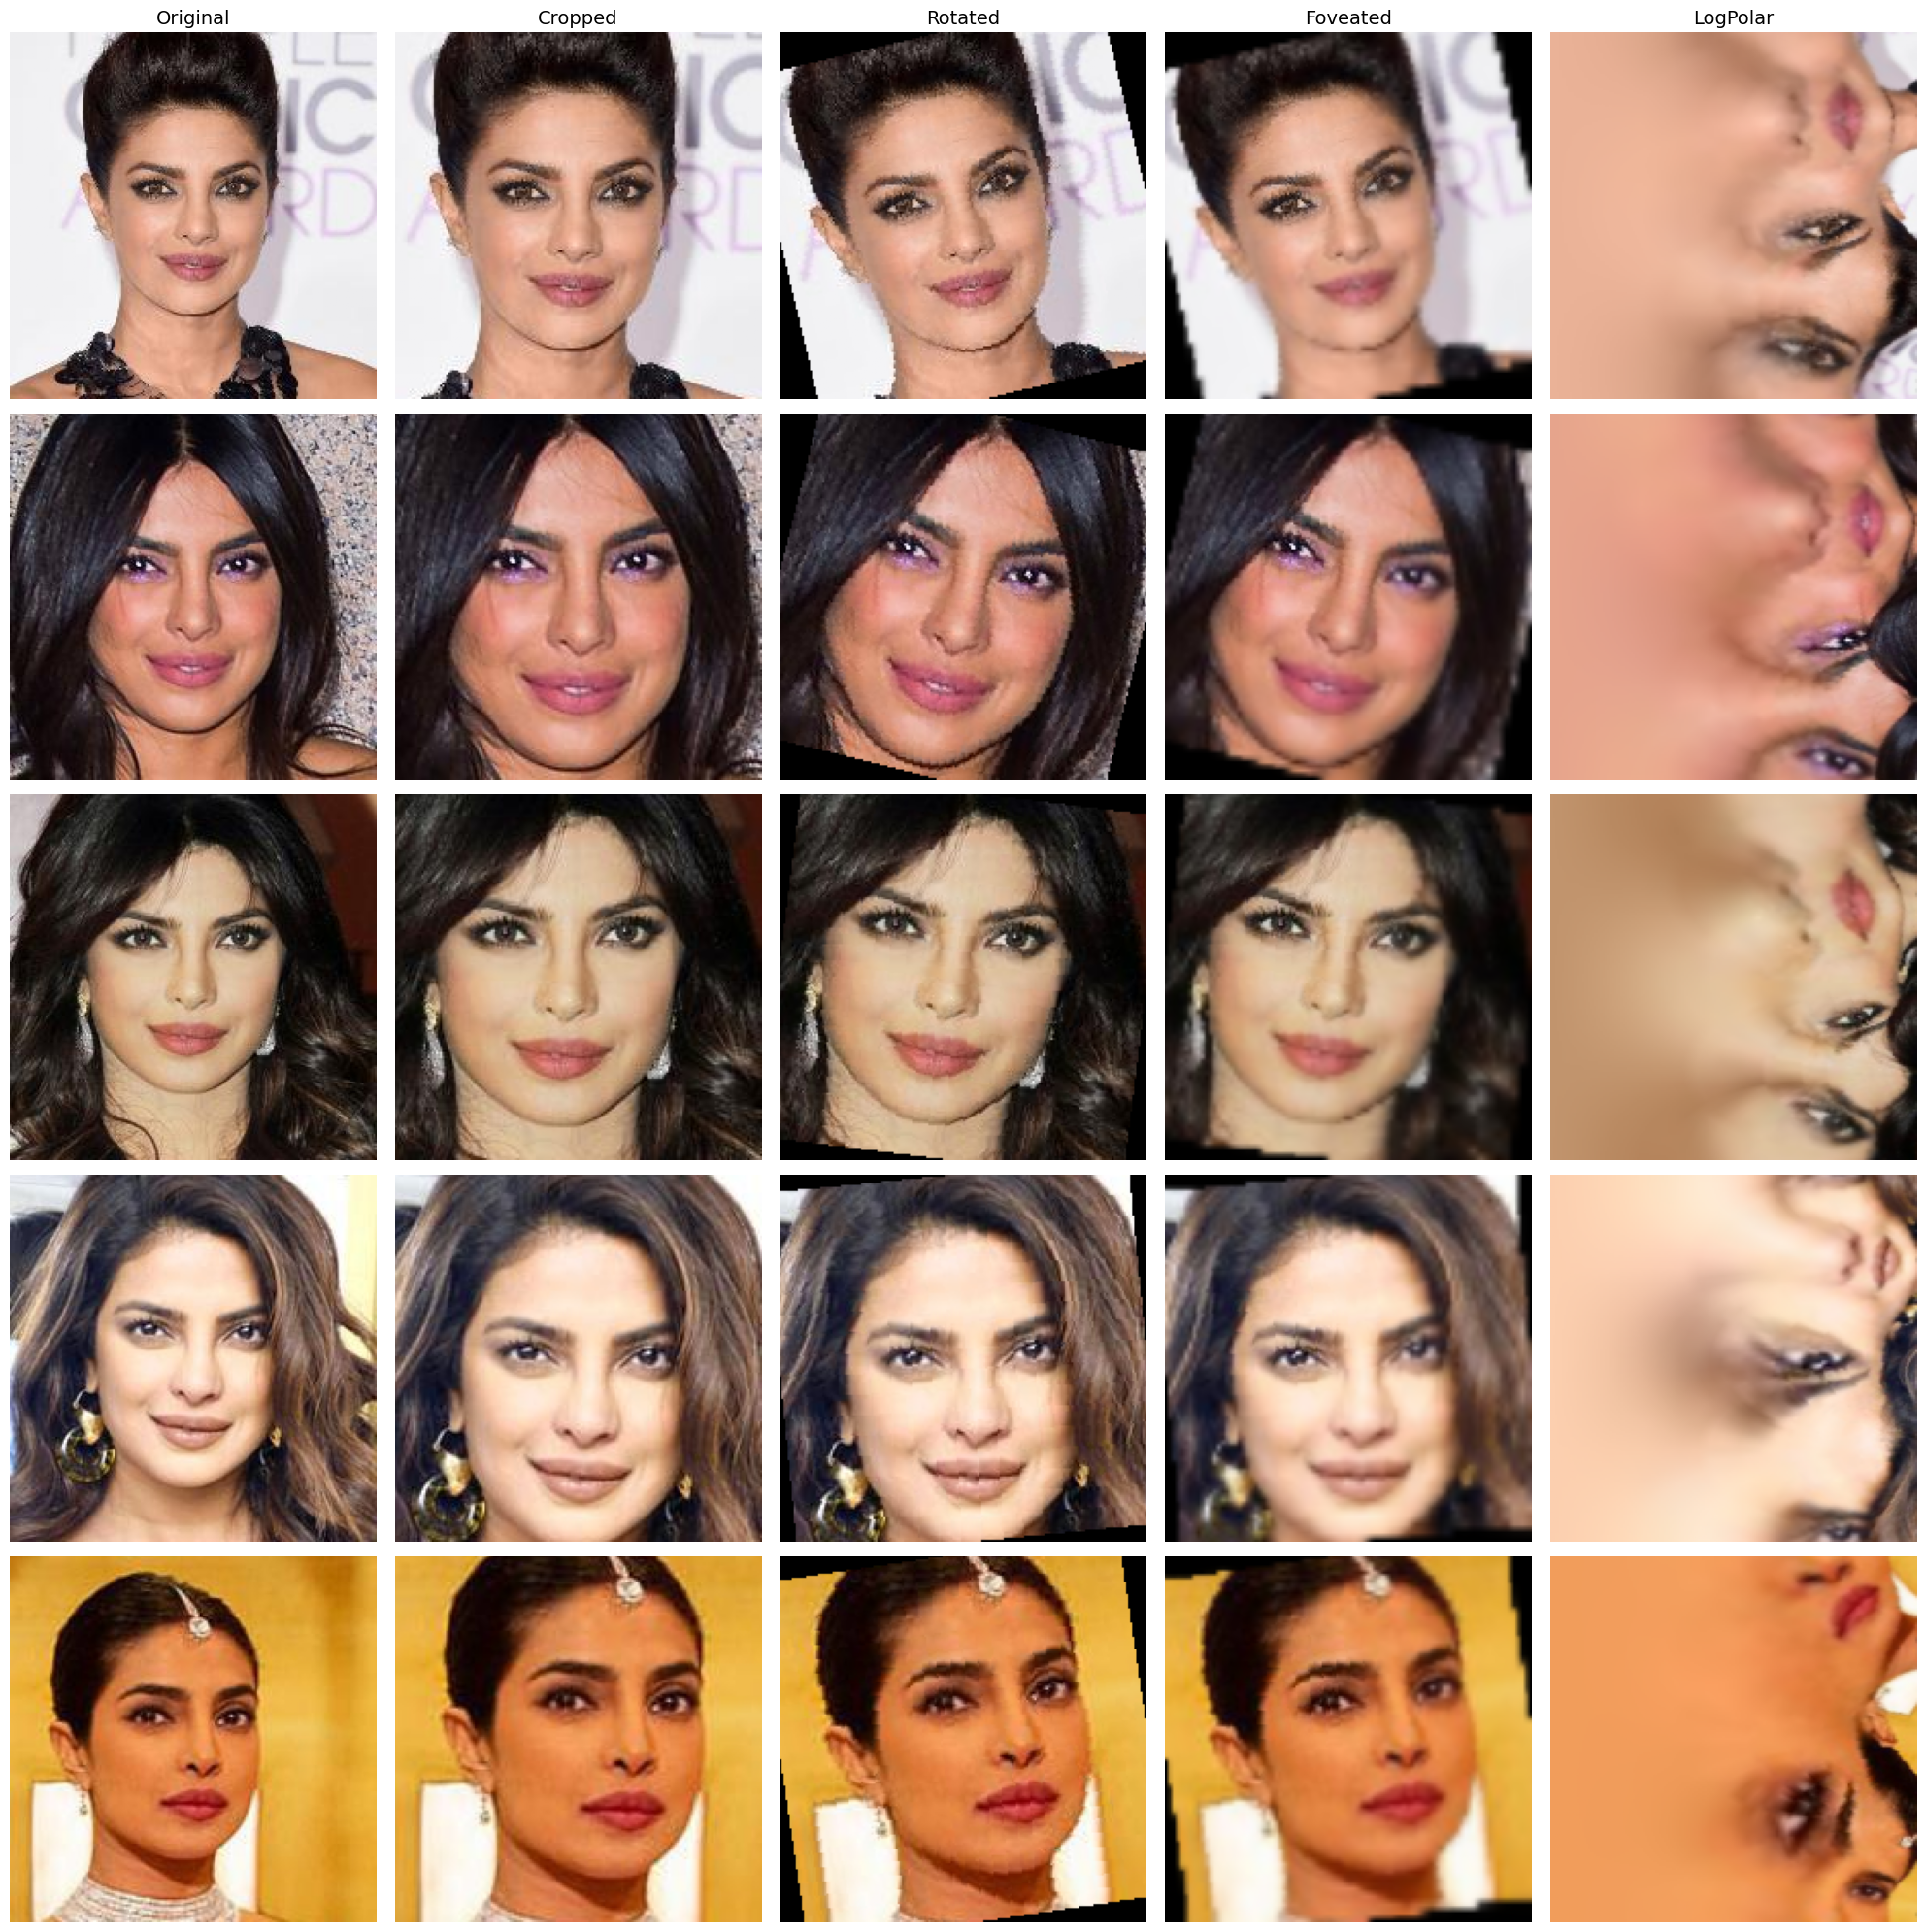

In [1]:
import matplotlib.pyplot as plt
import yaml
import random
import torch
import torchvision.transforms.functional as TF

from utils import *
from pipeline import build_transform_pipeline
from transformations import *
from pipeline import *

# ------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------

dataset_name = "faces"
identity_count = 128
split = "test"

# Load the config
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Create each transformation module separately
cropper = RandomCropper(crop_scale=config['params']['crop_scale'])
rotator = RandomRotator(degrees=config['params']['rotation_degrees'])
foveater = Foveater(
    crop_size=config['params']['crop_size'],
    sigma=config['params']['sigma'],
    prNum=config['params']['prNum']
)

logpolar = LogPolarTransformer(
    input_shape=(config['params']['crop_size'], config['params']['crop_size']),
    output_shape=tuple(config['params']['logpolar_output_shape'])
)

# Load dataset WITHOUT transform
ds = load_dataset(
    dataset=dataset_name,
    identity=identity_count,
    task=split,
    transform=None  # <-- important
)

# ------------------------------------------------------------------------
# Display Example Images with progressive transformation
# ------------------------------------------------------------------------


num_samples = 5  
#indices = random.sample(range(len(ds)), num_samples)
indices = [1700,1701,1702,1703,1704]

fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))  # 5 columns: Original, Cropped, Rotated, Foveated, LogPolar

for row_idx, idx in enumerate(indices):
    crops, label = ds[idx]  # crops is a list of 4 PIL images
    img = crops[0]

    if not isinstance(img, torch.Tensor):
        img = TF.to_tensor(img)

    # Step 1: Original
    img_orig = img.clone()

    # Step 2: Cropped
    img_pil = TF.to_pil_image(img_orig)
    cropped_list = cropper(img_pil)
    img_cropped = cropped_list[2]
    if not isinstance(img_cropped, torch.Tensor):
        img_cropped = TF.to_tensor(img_cropped)

    # Step 3: Rotated
    img_rotated = rotator(img_cropped)
    if not isinstance(img_rotated, torch.Tensor):
        img_rotated = TF.to_tensor(img_rotated)

    # Step 4: Foveated
    img_foveated = foveater(img_rotated)

    # Step 5: LogPolar
    img_logpolar = logpolar(img_foveated)

    # Collect all versions for easy plotting
    imgs = [img_orig, img_cropped, img_rotated, img_foveated, img_logpolar]
    titles = ["Original", "Cropped", "Rotated", "Foveated", "LogPolar"]

    # Plot in a row
    for col_idx, (im, title) in enumerate(zip(imgs, titles)):
        ax = axes[row_idx, col_idx] if num_samples > 1 else axes[col_idx]
        im_show = im.permute(1, 2, 0).cpu().numpy().clip(0, 1)
        ax.imshow(im_show)
        if row_idx == 0:
            ax.set_title(title, fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"Label: {label}", fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# import cv2
# print(cv2.__version__)
# print(hasattr(cv2, "cvtColor"))
# print(hasattr(cv2, "saliency"))
# print(hasattr(cv2.saliency, 'StaticSaliencySpectralResidual_create'))

4.5.5
True
True
True


In [3]:
# !pip uninstall opencv-python

#pip install opencv-contrib-python==4.5.5.64